# Pyiron workflows: Introduction and Syntax

Here we will highlight:
- How to instantiate a node
- How to make reusable node classes
- How to connect node inputs and outputs together
- SingleValue nodes and syntactic sugar
- Workflows: keeping your computational graphs organized
- Using pre-defined nodes 
- Macro nodes

## Instantiating a node

Simple nodes can be defined on-the-fly by passing any callable to the `Function(Node)` class. This transforms the function into a node instance which has input and output, can be connected to other nodes in a workflow, and can run the function it stores.

Input and output channels are _automatically_ extracted from the signature and return value(s) of the function. (Note: "Nodized" functions must have _at most_ one `return` expression!)

In [1]:
from pyiron_workflow.function import Function

In [2]:
def plus_minus_one(x):
    return x+1, x-1

pm_node = Function(plus_minus_one)

This has automatically created a node with input and output data channels whose labels are gathered by inspecting the function:

In [3]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['x+1', 'x-1']


The output is still empty (`NotData`) because we haven't `run()` the node:

In [4]:
print(pm_node.outputs.to_value_dict())

{'x+1': <class 'pyiron_workflow.channels.NotData'>, 'x-1': <class 'pyiron_workflow.channels.NotData'>}


If we try that now though, we'll just get a type error because the input is not set! 

In [5]:
# pm_node.run()

Not only will you get the expected error, but `pm_node` will also set its `failed` attribute to `True` -- this will prevent it from being `ready` again until you manually reset `pm_node.failed = False`.

In [6]:
# pm_node.failed = False

If we update the input, we'll give the node enough data to work with:

In [7]:
pm_node.inputs.x = 5
pm_node.run()
print(pm_node.outputs.to_value_dict())

{'x+1': 6, 'x-1': 4}


Alternatively, the `run()` command just return the function's return value:

In [8]:
out = pm_node.run()
out

(6, 4)

We can give our function defaults so that it's ready to go from the beginning. Let's also take the opportunity to give our output channel a better name so we can get it by dot-access.

In [9]:
def adder(x: int = 0, y: int = 1) -> int:
    sum_ = x + y
    return sum_

adder_node = Function(adder)
adder_node.run()
adder_node.outputs.sum_.value  # We use `value` to see the data the channel holds

1

This node also exploits type hinting! `run()` will check that input values conform to type hints before computing anything. Failing at this stage won't actually cause the node to have a `failed` status, so you can just re-run it once the input is fixed.

In [10]:
adder_node.inputs.x = "not an integer"
adder_node.inputs.x.type_hint, type(adder_node.inputs.x.value)
# adder_node.run()

(int, str)

In [11]:
adder_node.inputs.x = 2
adder_node.run()

3

We can also set new input as any valid combination of kwargs and/or args at both instantiation or on call:

In [12]:
adder_node = Function(adder, 10, y=20)
adder_node.run()

30

Finally, we can update input and then `run` together by calling an already-instantiated node. Just like at node instantiation, the input for `Function` nodes can be set by positional and/or keyword argument. Here we'll use two positional args:

In [13]:
adder_node(15, 16)

31

Note for advanced users: when the node has an executor set, running returns a futures object for the calculation, whose `.result()` will eventually be the function output.

## Reusable node classes

If we're going to use a node many times, we may want to define a new sub-class of `Function` to handle this.

The can be done directly by inheriting from `Function` and overriding it's `__init__` function so that the core functionality of the node (i.e. the node function and output labels) are set in stone, but even easier is to use the `function_node` decorator to do this for you! 

The decorator also lets us explicitly choose the names of our output channels by passing the `output_labels` argument to the decorator -- as a string to create a single channel for the returned values, or as a list of strings equal to the number of returned values in a returned tuple.

In [14]:
from pyiron_workflow.function import function_node

In [15]:
@function_node("diff")
def subtract_node(x: int | float = 1, y: int | float = 2) -> int | float:
    return x - y

sn = subtract_node()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)

sn()  # Runs without updating input data, but we have defaults so that's fine
print("default output =", sn.outputs.diff.value)

class name = SubtractNode
label = subtract_node
default output = -1


The decorator is just dynamically defining a new child of the `Function` class. These children have their behaviour available in the static method `node_function` so we can access it right from the class level, e.g. to modify the behaviour:

In [16]:
@function_node("square_diff")
def subtract_and_sqaure_node(x: int | float = 1, y: int | float = 2) -> int | float:
    return subtract_node.node_function(x, y)**2
    
ssq = subtract_and_sqaure_node()
ssq()
print("default output =", ssq.outputs.square_diff.value)

default output = 1


# Connecting nodes and controlling flow

Multiple nodes can be used together to build a computational graph, with each node performing a particular operation in the overall workflow.

The input and output of nodes can be chained together by connecting their data channels.

The flow of execution can be manually configured by using other "signal" channels. However, for acyclic graphs (DAGs), execution flow can be automatically determined from the topology of the data connections.

The `run` command we saw above has several boolean flags for controlling the style of execution. The two main run modes are with a "pull" paradigm, where everything upstream is run first then the node invoking `pull` gets run; and with a "push" paradigm (the default for `run`), where the node invoking `run` gets run and then runs everything downstream. Calling an instantiated node runs a particularly aggressive version of `pull`.

We'll talk more about grouping nodes together inside a `Workflow` object, but without a parent workflow, only the `pull` method will automate execution signals; trying to push data downstream using `run` requires specifying the execution flow manually.

Let's start by looking at `pull` in the example below to see how this works for a super-simple toy graph:

In [17]:
@function_node()
def linear(x):
    return x

@function_node("double")
def times_two(x):
    return 2 * x

l = linear()
t2 = times_two()

l.inputs.x = 1
t2.inputs.x = l.outputs.x
t2.signals.input.run = l.signals.output.ran

t2.pull()

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel ran was not connected to run, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


2

And, as mentioned, `__call__` is just (roughly) an alias for `pull`:

In [18]:
l.inputs.x = 2
t2()

4

Next, lets see how to do this with a "push" paradigm.

Just like the data connections, we can connect the `.signals.inputs.run` and `.signals.output.ran` channels of two nodes, but we can also use the `>` operator as a syntactic sugar shortcut.

Note how data connections can be made with keyword arguments just like other input data definitions.

With both of these together, we can write:

In [19]:
l = linear(x=10)
t2 = times_two(x=l.outputs.x)
l > t2  # Note: We can make arbitrarily long linear chains: l > t2 > something_else > another_node
l.run()
print(t2.inputs.x, t2.outputs.double)

10 20


## Single Value nodes

Many functions return just a single value. In this case, we can take advantage of the `SingleValue` node class which employs a bunch of syntactic tricks to make our lives easier.

The main difference between this and it's parent the `Function` class is that attribute and item access fall back to looking for attributes and items of this single output value.

Let's look at a use case:

In [20]:
import numpy as np

from pyiron_workflow.function import SingleValue

In [21]:
def linspace_node(
    start: int | float = 0, stop: int | float = 1, num: int = 50
):
    linspace = np.linspace(start=start, stop=stop, num=num)
    return linspace

lin = SingleValue(linspace_node)
lin()

print(type(lin.outputs.linspace.value))  # Output is just what we expect
print(lin[1:4])  # Gets items from the output
print(lin.mean())  # Finds the method on the output -- a special feature of SingleValueNode

<class 'numpy.ndarray'>
[0.02040816 0.04081633 0.06122449]
0.5


The other advantage is that single value nodes can also be connected directly to input, since there is only one possible data connection. Of course it has a construction decorator just like `Function`, so let's replace `@function_node` with `@single_value_node` in one of our examples above to see how it tightens up the syntax a bit:

In [22]:
from pyiron_workflow.function import single_value_node

@single_value_node()
def linear(x):
    return x

@single_value_node("double")
def times_two(x):
    return 2 * x

l = linear(x=2)
t2 = times_two(x=l)  # Just takes the whole `l` node!
t2.pull()

4

Nodes can take input from multiple sources, and -- although it's usually _useful_ to give each node its own variable -- we can even instantiate nodes inside the signature for initializing another node and call that node all at once! You won't have easy access to them, but this still just builds three nodes in memory, sets their data connections, and invokes a `pull` on the outermost (downstream-most) node, which automatically creates the execution flow and runs it:

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


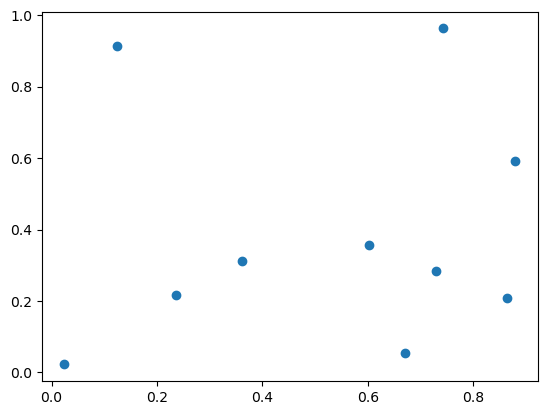

In [23]:
import matplotlib.pyplot as plt

@single_value_node()
def noise(length: int = 1):
    array =  np.random.rand(length)
    return array

@function_node()
def plot(x, y):
    fig = plt.scatter(x, y)
    return fig

plot_output = plot(
    x=noise(length=10),
    y=noise(length=10),
)()

# Workflows

The case where we have groups of connected nodes working together is our normal, intended use case.
We offer a formal way to group these objects together as a `Workflow(Node)` object.
`Workflow` also offers us a single point of entry to the codebase -- i.e. most of the time you shouldn't need the node imports used above, because the decorators are available right on the workflow class.

We will also see here that we can rename our node output channels using the `output_labels: Optional[str | list[str] | tuple[str]` kwarg, in case they don't have a convenient name to start with.
This way we can always have convenient dot-based access (and tab completion) instead of having to access things by string-based keys.

Finally, when a workflow is run, unless its `automate_execution` flag has been set to `False` or the data connections form a cyclic graph, it will _automatically_ build the necessary run signals! That means for all directed acyclic graph (DAG) workflows, all we typically need to worry about is the data connections.

Here is an example showing how `Workflow` can be used as a single-point-of-import for defining new nodes:

In [24]:
from pyiron_workflow import Workflow

@Workflow.wrap_as.single_value_node("is_greater")
def greater_than_half(x: int | float | bool = 0) -> bool:
    """The functionality doesn't matter here, it's just an example"""
    return x > 0.5

## Adding nodes to a workflow

Each node can belong to exactly one workflow...but how to we create a workflow and add nodes to it

All five of the approaches below are equivalent ways to add a node to a workflow. Note that when `create` is called from the workflow _class_ it just gives you access to the class being created; when it is called from a workflow _instance_, it wraps this class so that the created node has its parent value automatically set to the workflow instance that's creating it.

In [25]:
n1 = greater_than_half(label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.create.SingleValue(n1.node_function, output_labels="p1", label="n2")  # Instantiating from the class with a function
wf.add(greater_than_half(label="n3"))  # Instantiating then passing to node adder
wf.n4 = greater_than_half(label="will_get_overwritten_with_n4")  # Set attribute to instance
greater_than_half(label="n5", parent=wf)  # By passing the workflow to the node

for i, (label, node) in enumerate(wf.nodes.items()):
    x = i / len(wf)
    node(x=x)
    print(f"{label} == {node.label}) {x} > 0.5 {node.single_value}")

n1 == n1) 0.0 > 0.5 False
n2 == n2) 0.2 > 0.5 False
n3 == n3) 0.4 > 0.5 False
n4 == n4) 0.6 > 0.5 True
n5 == n5) 0.8 > 0.5 True


Workflows have inputs and outputs just like function nodes, but these are dynamically created to map to all _unconnected_ input and output for their underlying graph. They automatically get named by connecting the node label and channel label with a double underscore, but this can be overriden by providing an `inputs_map` and/or an `outputs_map` -- these maps can also let you expose data channels that would otherwise be hidden because they have a connection!

In [26]:
wf = Workflow("simple")

@Workflow.wrap_as.single_value_node()
def add_one(x):
    y = x + 1
    return y

@Workflow.wrap_as.single_value_node("sum")
def add_node(x, y):
    return x + y

wf.a = add_one(0)
wf.b = add_one(0)
wf.sum = add_node(wf.a, wf.b)  
wf.inputs_map = {"a__x": "ax"}
wf.outputs_map = {"a__y": "ay", "sum__sum": "a + b + 2"}
# Remember, with single value nodes we can pass the whole node instead of an output channel!

print(wf.inputs.labels, wf.outputs.labels)

['ax', 'b__x'] ['ay', 'a + b + 2']


When `run()` is called on a workflow, it will call `run()` on each node in its `starting_nodes` list and rely on these to propagate the execution with their run signals. If your data flow is DAG-like, all of this gets handled automatically so you just need to call `run()` on the workflow.

If you do have cyclic data flows, or just want more control, you are still free to set the `starting_nodes` and run signals yourself, just don't forget to set `automate_execution=False` on the workflow.

Unlike function nodes, workflow input has no intrinsic order. We can still update it by calling the workflow, but we _need_ to use keyword and not positional arguments. Runs of the workflow then return a dot-accessible dictionary based on the output channels:

In [27]:
out = wf(ax=2, b__x=3)
out

{'ay': 3, 'a + b + 2': 7}

Note: Workflows are the "parent-most" node, so even though `__call__` is still invoking a `pull`, the "run all upstream data dependencies" part of "run all upstream data dependencies then run yourself" gets skipped trivially -- workflows can't have siblings or parents so there are no dependencies to run! Thus `__call__` is effectively just a `run`.

We can see now why we've been trying to givesuccinct string labels to our `Function` node outputs instead of just arbitrary expressions! The expressions are typically not dot-accessible:

In [28]:
out["a + b + 2"], out.ay

(7, 3)

We can also look at our graph:

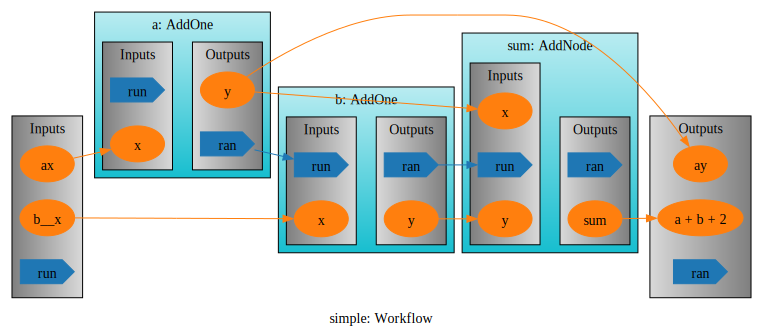

In [29]:
wf.draw()

# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

To access prebuilt nodes we can `.create` them. This works both from the workflow class _and_ from a workflow instance. In the latter case, created nodes automatically take the creating workflow instance as their `parent`.

There are a few of nodes that are always available under the `Workflow.create.standard` namespace, otherwise we need to register new node packages. This is done with the `register` method, which takes the domain (namespace/key/attribute/whatever you want to call it) under which you want to register the new nodes, and a string import path to a module that has a list of nodes under the name `nodes`, i.e. the module has the property `nodes: list[pyiron_workflow.nodes.Node]`. (This API is subject to change, as we work to improve usability and bring node packages more and more in line with "FAIR" principles.)

You can make your own `.py` files with nodes for reuse this way, but `pyiron_workflow` also comes with a couple of packages. In this example we'll use atomistics and plotting:

The job JUSTAJOBNAME was saved and received the ID: 9558


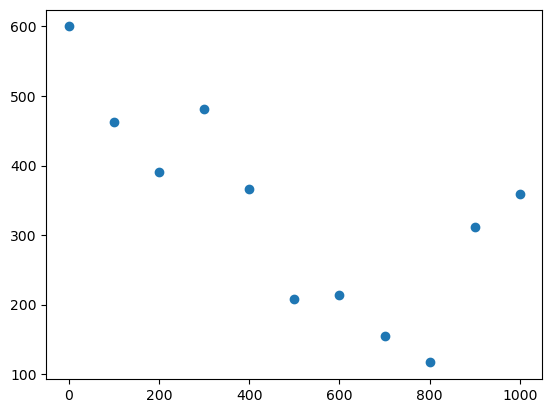

In [30]:
wf.register("atomistics", "pyiron_workflow.node_library.atomistics")
wf.register("plotting", "pyiron_workflow.node_library.plotting")

wf = Workflow("with_prebuilt")

wf.structure = wf.create.atomistics.Bulk(cubic=True, name="Al")
wf.engine = wf.create.atomistics.Lammps(structure=wf.structure)
wf.calc = wf.create.atomistics.CalcMd(job=wf.engine)
wf.plot = wf.create.plotting.Scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)

out = wf.run()
out.plot__fig

In case you want to see more or less of the inner workings of the nodes when visualizing a workflow, you can modify the `depth` parameter, which controls how deeply child nodes are decomposed. E.g. we can force our workflow to only show us it's basic IO by setting `depth=0`:

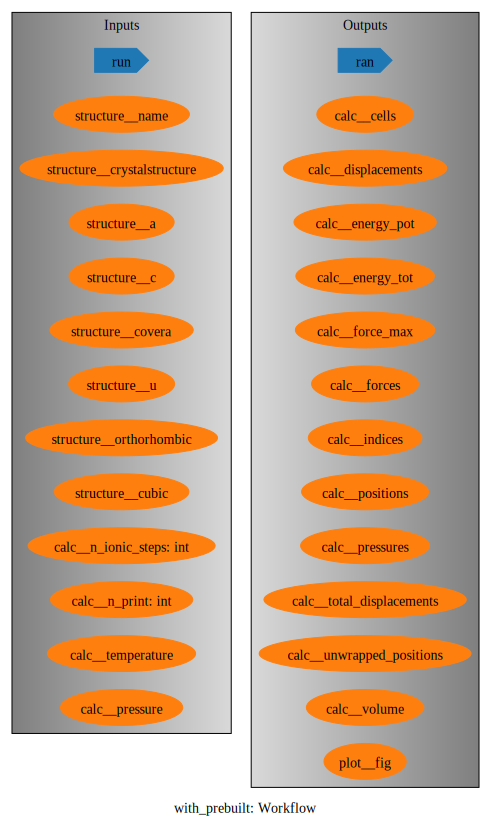

In [31]:
wf.draw(depth=0)

Note: the `draw` call returns a `graphviz.graphs.Digraphs` object; these get natively rendered alright in jupyter notebooks, as seen above, but you can also snag the object in a variable and do everything else graphviz allows, e.g. using the `render` method on the object to save it to file. Cf. the graphviz docs for details.

# Macros

Once you have a workflow that you're happy with, you may want to store it as a macro so it can be stored in a human-readable way, reused, and shared. Automated conversion of an existing `Workflow` instance into a `Macro` subclass is still on the TODO list, but defining a new macro is pretty easy: they are just composite nodes that have a function defining their graph setup:

In [32]:
from pyiron_workflow.macro import Macro

In [33]:
@Workflow.wrap_as.single_value_node("result")
def add_one(x):
    return x + 1

def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    # Just like workflows, for simple DAG macros we don't _need_
    # to set signals and starting nodes -- the macro will build them
    # automatically. But, if you do set both then the macro will use them
    macro.add_one > macro.add_two > macro.add_three
    macro.starting_nodes = [macro.add_one]  
    
macro = Macro(add_three_macro)
macro(add_one__x=10).add_three__result

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


13

Of course, we can also use a decorator like for other node types. This is shown below, along with an example of how exploit label maps to give our macro IO easier-to-use names (and expose IO that would be skipped by default because it's internally connected):

In [34]:
@Workflow.wrap_as.macro_node()
def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    macro.inputs_map = {"add_one__x": "x"}
    macro.outputs_map = {"add_three__result": "plus_three", "add_two__result": "intermediate"}
    
macro = add_three_macro()
macro(x=100)
macro.outputs.to_value_dict()

{'intermediate': 102, 'plus_three': 103}

## Nesting

Composite nodes can be nested to abstract workflows into simpler components -- i.e. macros can be added to workflows, and macros can be used inside of macros.

For our final example, let's define a macro for doing Lammps minimizations, then use this in a workflow to compare energies between different phases.

In [35]:
@Workflow.wrap_as.macro_node()
def lammps_minimize(macro):
    macro.structure = macro.create.atomistics.Bulk()
    macro.engine = macro.create.atomistics.Lammps(structure=macro.structure)
    macro.calc = macro.create.atomistics.CalcMin(job=macro.engine, pressure=0)
    
    macro.inputs_map = {
        "structure__name": "element", 
        "structure__crystalstructure": "crystalstructure",
        "structure__a": "lattice_guess",
    }
    macro.outputs_map = {
        "calc__energy_pot": "energy",
        "structure__structure": "structure",
    }

@Workflow.wrap_as.single_value_node()
def per_atom_energy_difference(structure1, energy1, structure2, energy2):
    # The unrelaxed structure is fine, we're just using it to get n_atoms
    de = (energy2[-1]/len(structure2)) - (energy1[-1]/len(structure1))
    return de

In [36]:
wf = Workflow("phase_preference")
wf.element = wf.create.standard.UserInput()
wf.min_phase1 = lammps_minimize(element=wf.element)
wf.min_phase2 = lammps_minimize(element=wf.element)
wf.compare = per_atom_energy_difference(
    wf.min_phase1.outputs.structure,
    wf.min_phase1.outputs.energy,
    wf.min_phase2.outputs.structure,
    wf.min_phase2.outputs.energy,
)

wf.inputs_map = {
    "element__user_input": "element",
    "min_phase1__crystalstructure": "phase1",
    "min_phase2__crystalstructure": "phase2",
    "min_phase1__lattice_guess": "lattice_guess1",
    "min_phase2__lattice_guess": "lattice_guess2",
}

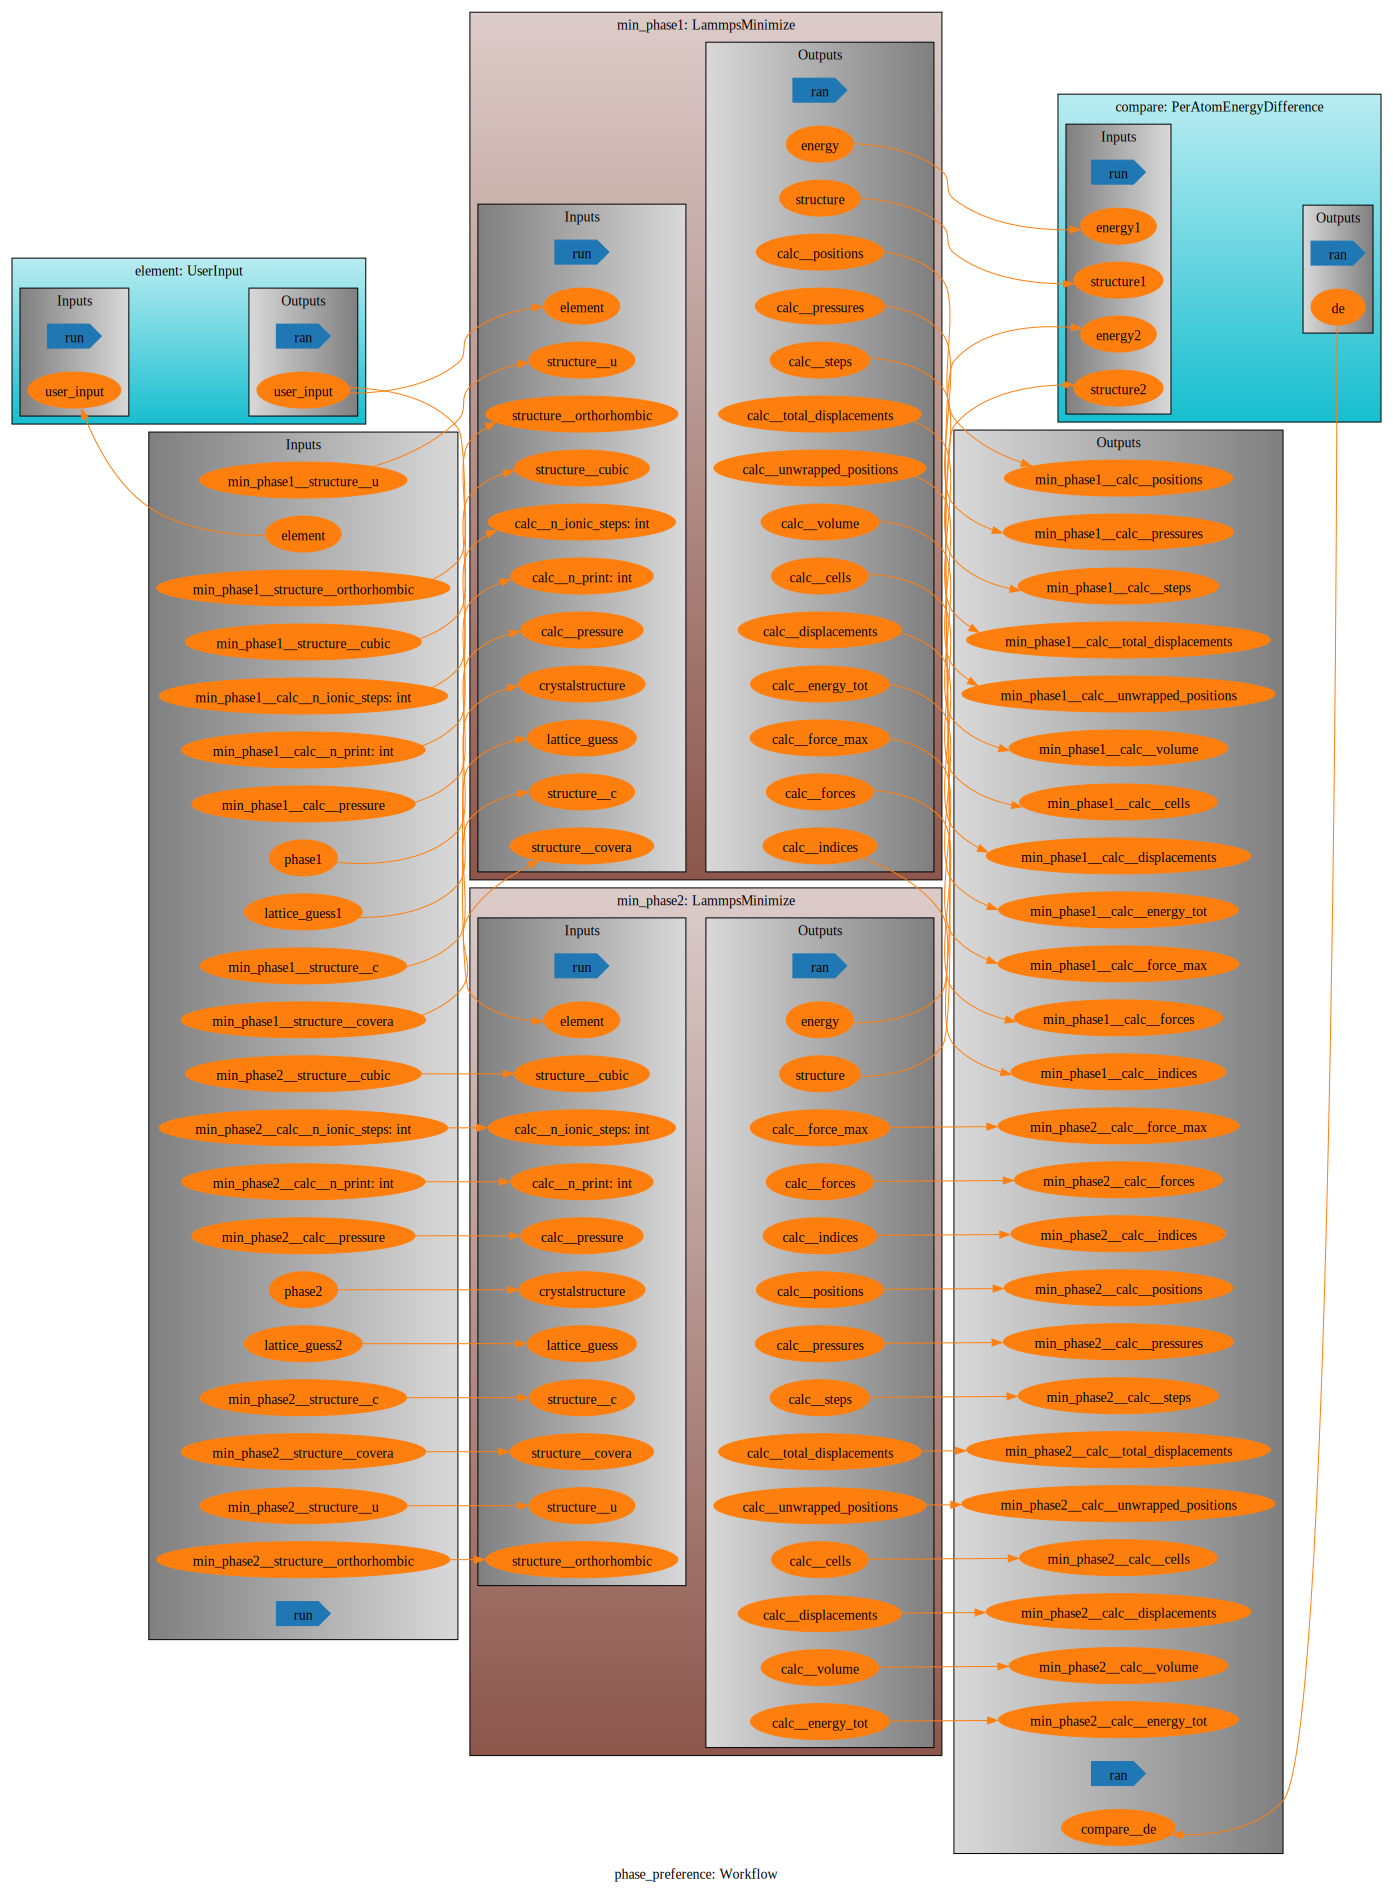

In [37]:
wf.draw()

In [38]:
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4, lattice_guess2=4)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Al: E(hcp) - E(fcc) = 1.17 eV/atom


In [39]:
out = wf(element="Mg", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel ran was not connected to run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Mg: E(hcp) - E(fcc) = -4.54 eV/atom


We can also replace entire node in a workflow or macro with a new node, booting the old one out and inserting the new one including all its connections. Because the connections are recreated, the replacement node _must_ have compatible IO to the node being replaced.

There are several syntacic approaches for doing this, including invoking replacement methods from the workflow (or macro) or from the node being replaced, or a new (compatible!) class can be assigned directly to an existing node. We'll use the last approach, which makes a new instance of the supplied class and replaces the target node with it.

Let's replace the calculation type for phase 1 -- let's switch it from a `CalcMin` to a `CalcStatic`; both of these take a `job` as input and give `structure` and `energy` as output, so we won't have any trouble connecting our new node in lieue of the old one.

In [40]:
replacee = wf.min_phase1.calc 
wf.min_phase1.calc = Macro.create.atomistics.CalcStatic

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel job was not connected to job, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel element was not connected to user_input, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel structure was not connected to structure1, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel energy was not connected to energy1, andthus could not disconnect from it.
  warn(


Since we're no longer allowing our first phase to relax while the second phase still can, we would expect the second phase to have a much lower energy than the first one. If our lattice guess for the first phase is bad enough, this could even switch the preferred phase!

Look at Al's fcc-hcp energy difference using this new workflow. We'll always let hcp relax, but freeze the fcc cell so we can see the impact of a good and bad lattice guess.

In [41]:
# Bad guess
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3.1)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel ran was not connected to run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Al: E(hcp) - E(fcc) = -5.57 eV/atom


In [42]:
# Good guess
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4.05, lattice_guess2=3.2)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__de:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel ran was not connected to run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Al: E(hcp) - E(fcc) = 0.03 eV/atom


Now that we have nested macros, we can finally discuss the subtle difference between `__call__` and `pull`:

Each `Macro` instance is its own little walled garden, where it's child nodes have no connections apart from those to other children of the same macro (you can forceably change this, since we're all adults here, but it won't happen by default and isn't recommended). Under the hood this is accomplished by the macro IO "linking" itself to its childrens' IO, so that updates to macro input values are always immediately propagated to children, and macro output gets synchronized with its childrens' output at the end of every run. Because of this we can think of these children all having the same "scope", i.e. siblings among the same parent.

`pull` has a keyword argument to determine whether upstream data dependencies are restricted to be _in scope_, or if the parent node (if any) should also consider all _its_ data dependencies as well, and so on up until we hit the parent-most macro or workflow.

For `pull` this parameter defaults to `False`, so that the pull stops at the parent node. For `__call__` it defaults to `True`, so that the search for data dependencies punches right through parents and all the way up. The danger is that this might be expensive if there's an costly node somewhere in the dependency!

Note that the entire "pull" paradigm does currently play nicely with remote execution. If some of your nodes have an executor specified, you will need to `.run` your graph (or `__call__` a `Workflow` if that's your parent-most object).

# Here be dragons

While everything in the workflows sub-module is under development, the following complex features are _even more likely_ to see substantial modifications to their interface and behaviour. Nonetheless, they're fun so let's look at them.

## Parallelization

You can currently run nodes in a single-core background process by setting that node's `executor` to `True`. The plan is to eventually lean on `pympipool` for more powerful executors that allow for multiple cores, interaction with HPC clusters, etc. We may also leverage the `Submitter` in `pyiron_contrib.tinybase` so that multiple nodes can lean on the same resources.

Unfortunately, _nested_ executors are not yet working. So if you set a macro to use an executor, none of its (grand...)children may specify an executor.

Note also that right now our treatment of DAGs is quite rudimentary, and the data flow is (unless cyclic) converted into a _linear_ execution pattern. 
This is practical and robust, but highly inefficient when combined with nodes that can run in parallel, i.e. with "executors".
Going forward, we will exploit the same infrastructure of data flow DAGs and run signals to build up more sophisticated execution patterns which support parallelization.

## Serialization and node libraries

Serialization for storage doesn't exist yet.

What you _can_ do is `register` new modules that have a list of nodes (including macros) with the workflow, so feel free to build up your own `.py` files containing nodes you like to use for easy re-use. Registration is now discussed in the main body of the notebook, but the API may change significantly going forward.

Serialization of workflows is still forthcoming, while for node registration flexibility and documentation is forthcoming but the basics are here already.

## Meta-nodes and flow control

A meta-node is a function that produces a node _class_ instedad of a node _instance_.
Right now, these are used to produce parameterized flow-control nodes, which take an node class as input and return a new macro class that builds some graph using the passed node class, e.g. for- and while-loops.

### For-loops

One meta node is a for-loop builder, which creates a macro with $n$ internal instances of the "loop body" node class, and a new IO interface.
The new input allows you to specify which input channels are being looped over -- such that the macro input for this channel is interpreted as list-like and distributed to all the copies of the nodes separately --, and which is _not_ being looped over -- and thus interpreted as the loop body node would normally interpret the input and passed to all copies equally.
All of the loop body outputs are then collected as a list of length $n$.

We follow a convention that inputs and outputs being looped over are indicated by their channel labels being ALL CAPS.

In the example below, we loop over the bulk structure node to create structures with different lattice constants:

In [43]:
n = 5

bulk_loop = Workflow.create.meta.for_loop(
    Workflow.create.atomistics.Bulk,
    n,
    iterate_on=("a",),
)()

out = bulk_loop(
    name="Al",  # Sent equally to each body node
    A=np.linspace(3.9, 4.1, n).tolist(),  # Distributed across body nodes
)

[struct.cell.volume for struct in out.STRUCTURE]  
# output is a list collected from copies of the body node, as indicated by CAPS label

[14.829749999999995,
 15.407468749999998,
 15.999999999999998,
 16.60753125,
 17.230249999999995]

## While-loops

We can also create a while-loop, which takes both a body node and a condition node. The condition node must be a `SingleValue` returning a `bool` type. Instead of creating copies of the body node, the body node gets re-run until the condition node returns `False`.

You _must_ specify the data connection so that the body node passes information to the condition node. You may optionally also loop output of the body node back to input of the body node to change the input at each iteration. Right now this is done with horribly ugly string tuples, but we're still working on it.

In [44]:
@Workflow.wrap_as.single_value_node()
def add(a, b):
    print(f"{a} + {b} = {a + b}")
    return a + b

@Workflow.wrap_as.single_value_node()
def less_than_ten(value):
    return value < 10

AddWhile = Workflow.create.meta.while_loop(
    loop_body_class=add,
    condition_class=less_than_ten,
    internal_connection_map=[
        ("Add", "a + b", "LessThanTen", "value"),
        ("Add", "a + b", "Add", "a")
    ],
    inputs_map={"Add__a": "a", "Add__b": "b"},
    outputs_map={"Add__a + b": "total"}
)

wf = Workflow("do_while")
wf.add_while = AddWhile()

wf.inputs_map = {
    "add_while__a": "a",
    "add_while__b": "b"
}
wf.outputs_map = {
    "add_while__total": "total",  # Rename this output
    "add_while__switch__truth": None  # Disable this output
}

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to true, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:158: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


Note that initializing the `a` and `b` input to numeric values when we call the workflow below does not destroy the connection made between the body node input and output -- so the first run of the body node uses the initial value passed, but then it updates its own input for subsequent calls!

In [45]:
response = wf(a=1, b=2)
print("Finally", response)

1 + 2 = 3
3 + 2 = 5
5 + 2 = 7
7 + 2 = 9
9 + 2 = 11
Finally {'total': 11}


In [46]:
@Workflow.wrap_as.single_value_node("random")
def random(length: int | None = None):
    return np.random.random(length)

@Workflow.wrap_as.single_value_node()
def greater_than(x: float, threshold: float):
    gt = x > threshold
    symbol = ">" if gt else "<="
    print(f"{x:.3f} {symbol} {threshold}")
    return gt

RandomWhile = Workflow.create.meta.while_loop(
    loop_body_class=random,
    condition_class=greater_than,
    internal_connection_map=[("Random", "random", "GreaterThan", "x")],
    outputs_map={"Random__random": "capped_result"}
)

# Define workflow

wf = Workflow("random_until_small_enough")

## Wire together the while loop and its condition

wf.random_while = RandomWhile()

## Give convenient labels
wf.inputs_map = {"random_while__GreaterThan__threshold": "threshold"}
wf.outputs_map = {"random_while__capped_result": "capped_result"}

print(f"Finally {wf(threshold=0.2).capped_result:.3f}")

0.639 > 0.2
0.481 > 0.2
0.582 > 0.2
0.213 > 0.2
0.829 > 0.2
0.826 > 0.2
0.401 > 0.2
0.929 > 0.2
0.251 > 0.2
0.525 > 0.2
0.087 <= 0.2
Finally 0.087
